load data and transfor it properly

In [4]:
df = pd.read_csv('data/creditcard_newds.csv')
print(df.head())
ds = df.to_numpy()

       Time        V1        V2        V3        V4        V5        V6  \
0   82450.0  1.314539  0.590643 -0.666593  0.716564  0.301978 -1.125467   
1   50554.0 -0.798672  1.185093  0.904547  0.694584  0.219041 -0.319295   
2   55125.0 -0.391128 -0.245540  1.122074 -1.308725 -0.639891  0.008678   
3  116572.0 -0.060302  1.065093 -0.987421 -0.029567  0.176376 -1.348539   
4   90434.0  1.848433  0.373364  0.269272  3.866438  0.088062  0.970447   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0  0.388881 -0.288390 -0.132137  ... -0.170307 -0.429655 -0.141341 -0.200195   
1  0.495236  0.139269 -0.760214  ...  0.202287  0.578699 -0.092245  0.013723   
2 -0.701304 -0.027315 -2.628854  ... -0.133485  0.117403 -0.191748 -0.488642   
3  0.775644  0.134843 -0.149734  ...  0.355576  0.907570 -0.018454 -0.126269   
4 -0.721945  0.235983  0.683491  ...  0.103563  0.620954  0.197077  0.692392   

        V25       V26       V27       V28  Amount  Class  
0  0.6394

separate features from classes

In [5]:
y = ds[:, -1] # for last column
x = ds[:, :-1] # for all but last column

create Training and Test datasets

In [6]:
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(y_train.shape)

(13808,)
(9665, 30)
(9665,)


# Trainiere XGBoost

# Unten befindet sich ein Model mit gesetzten Parameters, der nächste Schritt wird es sein die besten Parameters für XGboost aufzufinden. Die Anzahl der Parameter ist hier aufgelistet: https://xgboost.readthedocs.io/en/stable/parameter.html

In [7]:
# parameters
# https://xgboost.readthedocs.io/en/stable/parameter.html
eta = 1
gamma = 5
max_depth = 7
base_score = 0
lmbd = 0

# train a model with single tree
Xd = xgb.DMatrix(X_train, label=y_train)
model = xgb.train({
    'eta':eta, 'gamma': 6, 'max_depth':max_depth, 'base_score': base_score, "lambda": 0, 'eval_metric': 'auc',
}, Xd, 1)

print("Model error =", np.linalg.norm(y_train-model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])

Model error = 14.605272743330623
0:[f14<-2.02730823] yes=1,no=2,missing=1,gain=1863.45825,cover=9665
	1:[f12<-1.1369288] yes=3,no=4,missing=3,gain=50.5510254,cover=3777
		3:[f10<1.81592369] yes=7,no=8,missing=7,gain=8.91503906,cover=3486
			7:leaf=0.996548772,cover=3477
			8:leaf=-0,cover=9
		4:[f4<1.80614364] yes=9,no=10,missing=9,gain=25.9578323,cover=291
			9:[f10<-1.66757154] yes=17,no=18,missing=17,gain=10.1112671,cover=171
				17:leaf=0.75,cover=40
				18:leaf=0.175572515,cover=131
			10:leaf=0.916666687,cover=120
	2:[f17<-1.61795545] yes=5,no=6,missing=5,gain=69.5863342,cover=5888
		5:leaf=0.964285731,cover=84
		6:[f4<1.70284641] yes=13,no=14,missing=13,gain=24.976429,cover=5804
			13:[f14<-0.931567669] yes=23,no=24,missing=23,gain=8.71987724,cover=5266
				23:[f4<0.80391252] yes=35,no=36,missing=35,gain=11.0645723,cover=548
					35:leaf=0.0735632181,cover=435
					36:[f12<-0.423833311] yes=57,no=58,missing=57,gain=8.36819458,cover=113
						57:leaf=0.848484874,cover=33
						58

In [8]:
dtest = xgb.DMatrix(X_test, label=y_test)
ypred = model.predict(dtest)

By default, the predictions made by XGBoost are probabilities. Because this is a binary classification problem, each prediction is the probability of the input pattern belonging to the first class. We can easily convert them to binary class values by rounding them to 0 or 1.

In [9]:
predictions = np.array([round(value) for value in ypred])
print(len(predictions[predictions == 1]))
print(len(predictions[predictions == 0]))

1640
2503


## hier ist die Evaluation des XGBoost'es

In [10]:
print('Accuracy: ', accuracy_score(predictions, y_test))
print('Precision: ', precision_score(predictions, y_test))
print('Recall: ', recall_score(predictions, y_test))

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
false_positive_rate = fp / (fp + tn)

print('false positive rate', false_positive_rate)

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
false_negative_rate = fn / (tp + fn)

print('false negative rate: ', false_negative_rate)

Accuracy:  0.9698286265990828
Precision:  0.9453262786596119
Recall:  0.9804878048780488
false positive rate 0.013104013104013105
false negative rate:  0.054673721340388004


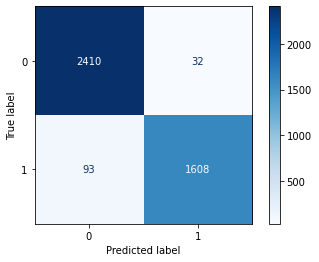

Anzahl der Frauds:  1701


In [11]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('Anzahl der Frauds: ', len(y_test[y_test==1]))

In [12]:
# das model wird gespeichert
model.save_model('models/xgboost.model')